---
## 1️⃣ Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [2]:
# Load raw data
URL_DATA = 'https://storage.data.gov.my/publicsafety/crime_district.parquet'
df_raw = pd.read_parquet(URL_DATA)

print(f"📊 Raw Dataset loaded successfully!")
print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"Memory: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📊 Raw Dataset loaded successfully!
Shape: 19,152 rows × 6 columns
Memory: 5.71 MB


In [3]:
# Prepare datetime features
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw['year'] = df_raw['date'].dt.year

print("✓ Date features added")

✓ Date features added


---
## 2️⃣ Data Cleaning
**Issue:** Hierarchical aggregates cause double-counting  
**Solution:** Remove national and state-level totals, keep only district-level data

In [4]:
# Before cleaning
print("📊 BEFORE CLEANING:")
print(f"Total rows: {len(df_raw):,}")
print(f"National level (Malaysia): {len(df_raw[df_raw['state'] == 'Malaysia']):,}")
print(f"State level (All): {len(df_raw[df_raw['district'] == 'All']):,}")
print(f"District level: {len(df_raw[(df_raw['state'] != 'Malaysia') & (df_raw['district'] != 'All')]):,}")

📊 BEFORE CLEANING:
Total rows: 19,152
National level (Malaysia): 112
State level (All): 1,680
District level: 17,472


In [5]:
# Clean: Remove aggregates
df_clean = df_raw[
    (df_raw['state'] != 'Malaysia') & 
    (df_raw['district'] != 'All')
].copy()

print("\n✓ AFTER CLEANING:")
print(f"Total rows: {len(df_clean):,}")
print(f"Rows removed: {len(df_raw) - len(df_clean):,}")
print(f"Reduction: {((len(df_raw) - len(df_clean)) / len(df_raw) * 100):.1f}%")


✓ AFTER CLEANING:
Total rows: 17,472
Rows removed: 1,680
Reduction: 8.8%


In [6]:
# Verify no aggregates remain
assert df_clean['state'].nunique() < df_raw['state'].nunique(), "Malaysia state should be removed"
assert 'All' not in df_clean['district'].unique(), "'All' districts should be removed"

print("\n✓ Validation passed: All aggregates removed")
print(f"Unique states: {df_clean['state'].nunique()}")
print(f"Unique districts: {df_clean['district'].nunique()}")


✓ Validation passed: All aggregates removed
Unique states: 14
Unique districts: 159


---
## 3️⃣ Feature Engineering - Temporal Features
Create year-over-year change metrics for trend analysis

In [7]:
# Create base aggregation: district-year level (PROPERTY CRIMES ONLY)
df_temporal = df_clean[
    (df_clean['type'] == 'all') & 
    (df_clean['category'] == 'property')
].copy()

print(f"📊 Temporal dataset (Property Crimes Only): {len(df_temporal):,} rows")
print(f"Levels: {df_temporal['district'].nunique()} districts × {df_temporal['year'].nunique()} years")
print(f"\n⚠️ RESEARCH FOCUS: Property crimes only (assault/violence excluded)")

📊 Temporal dataset (Property Crimes Only): 1,248 rows
Levels: 159 districts × 8 years

⚠️ RESEARCH FOCUS: Property crimes only (assault/violence excluded)


In [8]:
# Calculate year-over-year (YoY) change
df_temporal = df_temporal.sort_values(['state', 'district', 'year'])

df_temporal['crimes_prev_year'] = df_temporal.groupby(['state', 'district'])['crimes'].shift(1)
df_temporal['yoy_change'] = df_temporal['crimes'] - df_temporal['crimes_prev_year']
df_temporal['yoy_change_pct'] = (df_temporal['yoy_change'] / df_temporal['crimes_prev_year'] * 100).round(2)

# Replace inf values (division by zero) with NaN
df_temporal['yoy_change_pct'] = df_temporal['yoy_change_pct'].replace([np.inf, -np.inf], np.nan)

print("\n✓ YoY features created (Property Crimes):")
print(f"  • yoy_change (absolute)")
print(f"  • yoy_change_pct (percentage)")
print(f"\nSample (Property Crimes Only):")
df_temporal[['state', 'district', 'year', 'crimes', 'yoy_change', 'yoy_change_pct']].head(10)


✓ YoY features created (Property Crimes):
  • yoy_change (absolute)
  • yoy_change_pct (percentage)

Sample (Property Crimes Only):


,state,district,year,crimes,yoy_change,yoy_change_pct
288,Johor,Batu Pahat,2016,621,NaN,NaN
289,Johor,Batu Pahat,2017,558,-63.0,-10.14
290,Johor,Batu Pahat,2018,584,26.0,4.66
291,Johor,Batu Pahat,2019,524,-60.0,-10.27
292,Johor,Batu Pahat,2020,415,-109.0,-20.80
293,Johor,Batu Pahat,2021,200,-215.0,-51.81
294,Johor,Batu Pahat,2022,262,62.0,31.00
295,Johor,Batu Pahat,2023,285,23.0,8.78
400,Johor,Iskandar Puteri,2016,0,NaN,NaN
401,Johor,Iskandar Puteri,2017,727,727.0,NaN


---
## 4️⃣ Feature Engineering - District Profiles
Create district-level features for clustering and classification

In [9]:
# Aggregate by district (all years combined) - Property crimes only
df_district_wide = df_temporal.groupby(['state', 'district']).agg({
    'crimes': ['sum', 'mean', 'std', 'min', 'max']
}).reset_index()

# Flatten column names
df_district_wide.columns = ['state', 'district', 'total_crimes', 'avg_crimes', 'std_crimes', 'min_crimes', 'max_crimes']

print(f"📊 District profile dataset (Property Crimes Only): {len(df_district_wide):,} rows")
print(f"Features: Total, average, std dev, min, max property crimes per district")
df_district_wide.head(10)

📊 District profile dataset (Property Crimes Only): 159 rows
Features: Total, average, std dev, min, max property crimes per district


,state,district,total_crimes,avg_crimes,std_crimes,min_crimes,max_crimes
0,Johor,Batu Pahat,3449,431.125,163.785956,200,621
1,Johor,Iskandar Puteri,3969,496.125,271.458725,0,784
2,Johor,Johor Bahru Selatan,12345,1543.125,801.915107,609,2802
3,Johor,Johor Bahru Utara,7201,900.125,494.835452,354,1628
4,Johor,Kluang,3119,389.875,133.246750,204,535
5,Johor,Kota Tinggi,2758,344.750,136.192878,169,494
6,Johor,Kulaijaya,3208,401.000,181.458378,211,617
7,Johor,Ledang,1171,146.375,57.393224,71,220
8,Johor,Mersing,717,89.625,22.896896,63,120
9,Johor,Muar,1802,225.250,41.698750,171,298


In [10]:
# Calculate additional statistical features
df_district_wide['crime_range'] = df_district_wide['max_crimes'] - df_district_wide['min_crimes']
df_district_wide['coefficient_variation'] = (df_district_wide['std_crimes'] / df_district_wide['avg_crimes'] * 100).round(2)

print(f"\n✓ Additional features calculated:")
print(f"  • crime_range: Spread between min and max years")
print(f"  • coefficient_variation: Volatility measure (higher = more unstable)")
df_district_wide.head()


✓ Additional features calculated:
  • crime_range: Spread between min and max years
  • coefficient_variation: Volatility measure (higher = more unstable)


,state,district,total_crimes,avg_crimes,std_crimes,min_crimes,max_crimes,crime_range,coefficient_variation
0,Johor,Batu Pahat,3449,431.125,163.785956,200,621,421,37.99
1,Johor,Iskandar Puteri,3969,496.125,271.458725,0,784,784,54.72
2,Johor,Johor Bahru Selatan,12345,1543.125,801.915107,609,2802,2193,51.97
3,Johor,Johor Bahru Utara,7201,900.125,494.835452,354,1628,1274,54.97
4,Johor,Kluang,3119,389.875,133.246750,204,535,331,34.18


In [11]:
# Calculate crime trend indicator (increasing vs decreasing)
# Compare first half vs second half of time period
years_list = sorted(df_temporal['year'].unique())
mid_year = years_list[len(years_list)//2]

first_half = df_temporal[df_temporal['year'] <= mid_year].groupby(['state', 'district'])['crimes'].mean().reset_index()
first_half.columns = ['state', 'district', 'avg_first_half']

second_half = df_temporal[df_temporal['year'] > mid_year].groupby(['state', 'district'])['crimes'].mean().reset_index()
second_half.columns = ['state', 'district', 'avg_second_half']

df_district_wide = df_district_wide.merge(first_half, on=['state', 'district'], how='left')
df_district_wide = df_district_wide.merge(second_half, on=['state', 'district'], how='left')

df_district_wide['trend_direction'] = df_district_wide.apply(
    lambda x: 'Increasing' if x['avg_second_half'] > x['avg_first_half'] else 'Decreasing', axis=1
)

print("✓ Crime trend indicator calculated")
print(f"\nTrend Analysis ({years_list[0]}-{mid_year} vs {mid_year+1}-{years_list[-1]}):")
print(df_district_wide['trend_direction'].value_counts())

✓ Crime trend indicator calculated

Trend Analysis (2016-2020 vs 2021-2023):
trend_direction
Decreasing    146
Increasing     13
Name: count, dtype: int64


---
## 5️⃣ Risk Classification
Create risk levels for classification models

In [12]:
# Calculate average annual crimes per district
years_in_data = df_clean['year'].nunique()
df_district_wide['avg_annual_crimes'] = (df_district_wide['total_crimes'] / years_in_data).round(0)

print(f"📊 Average annual crimes calculated (across {years_in_data} years)")
print(f"\nDistribution:")
print(df_district_wide['avg_annual_crimes'].describe())

📊 Average annual crimes calculated (across 8 years)

Distribution:
count     159.000000
mean      380.138365
std       464.889853
min         6.000000
25%        74.000000
50%       169.000000
75%       466.500000
max      2195.000000
Name: avg_annual_crimes, dtype: float64


In [13]:
# Define risk levels using percentiles
q25 = df_district_wide['avg_annual_crimes'].quantile(0.25)
q50 = df_district_wide['avg_annual_crimes'].quantile(0.50)
q75 = df_district_wide['avg_annual_crimes'].quantile(0.75)

def classify_risk(avg_crimes):
    if avg_crimes <= q25:
        return 'Low'
    elif avg_crimes <= q50:
        return 'Medium-Low'
    elif avg_crimes <= q75:
        return 'Medium-High'
    else:
        return 'High'

df_district_wide['risk_level'] = df_district_wide['avg_annual_crimes'].apply(classify_risk)

print("\n✓ Risk levels assigned:")
print(f"  • Low: ≤ {q25:.0f} crimes/year (Q1)")
print(f"  • Medium-Low: {q25:.0f} - {q50:.0f} (Q2)")
print(f"  • Medium-High: {q50:.0f} - {q75:.0f} (Q3)")
print(f"  • High: > {q75:.0f} (Q4)")

print("\n📊 Risk level distribution:")
print(df_district_wide['risk_level'].value_counts().sort_index())


✓ Risk levels assigned:
  • Low: ≤ 74 crimes/year (Q1)
  • Medium-Low: 74 - 169 (Q2)
  • Medium-High: 169 - 466 (Q3)
  • High: > 466 (Q4)

📊 Risk level distribution:
risk_level
High           40
Low            40
Medium-High    39
Medium-Low     40
Name: count, dtype: int64


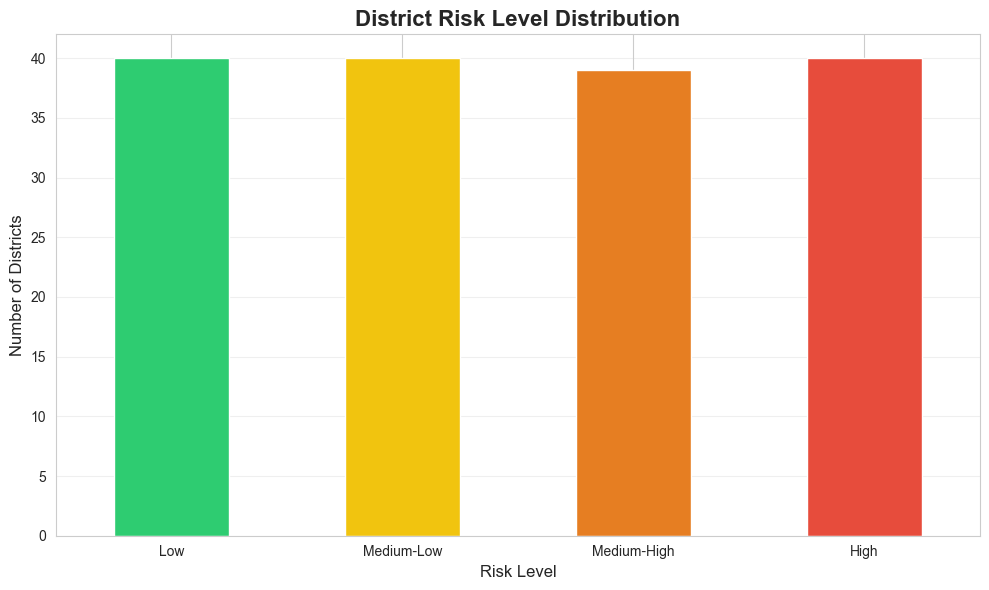

In [14]:
# Visualize risk distribution
plt.figure(figsize=(10, 6))
risk_counts = df_district_wide['risk_level'].value_counts()
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
risk_order = ['Low', 'Medium-Low', 'Medium-High', 'High']

risk_counts.reindex(risk_order).plot(kind='bar', color=colors)
plt.title('District Risk Level Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Number of Districts', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6️⃣ Time Series Preparation
Create aggregated datasets for forecasting

In [15]:
# State-level time series (for forecasting) - Property crimes only
df_state_ts = df_temporal.groupby(['state', 'year']).agg({
    'crimes': 'sum'
}).reset_index()

print(f"📊 State-level time series (Property Crimes Only): {len(df_state_ts):,} rows")
print(f"States: {df_state_ts['state'].nunique()}")
print(f"Years: {df_state_ts['year'].nunique()}")
print(f"Focus: Property crimes only")

df_state_ts.head(10)

📊 State-level time series (Property Crimes Only): 112 rows
States: 14
Years: 8
Focus: Property crimes only


,state,year,crimes
0,Johor,2016,10121
1,Johor,2017,8729
2,Johor,2018,8458
3,Johor,2019,7947
4,Johor,2020,5966
5,Johor,2021,3440
6,Johor,2022,3489
7,Johor,2023,4102
8,Kedah,2016,6201
9,Kedah,2017,5763


In [16]:
# National-level time series - Property crimes only
df_national_ts = df_temporal.groupby(['year']).agg({
    'crimes': 'sum'
}).reset_index()

print(f"📊 National-level time series (Property Crimes Only): {len(df_national_ts):,} rows")
print(f"Years: {df_national_ts['year'].nunique()}")
print(f"Focus: Aggregated property crimes across all districts")

df_national_ts

📊 National-level time series (Property Crimes Only): 8 rows
Years: 8
Focus: Aggregated property crimes across all districts


,year,crimes
0,2016,90028
1,2017,77804
2,2018,71760
3,2019,66967
4,2020,52664
5,2021,41848
6,2022,40465
7,2023,41991


---
## 7️⃣ Export Datasets
Save cleaned and transformed datasets for analysis

In [17]:
# Create output directory
output_dir = Path('cleaned_data')
output_dir.mkdir(exist_ok=True)

print(f"📁 Output directory: {output_dir.absolute()}")

📁 Output directory: c:\Users\erwan\OneDrive\Documents\Study\MSc Business Intelligence\Semester 1\MRTB1133 - BI\mrtb1133_group_assignment\cleaned_data


In [18]:
# 1. Full cleaned dataset (for PowerBI)
output_file = output_dir / 'crime_data_cleaned.parquet'
df_clean.to_parquet(output_file, index=False)
print(f"✓ Saved: {output_file.name} ({len(df_clean):,} rows)")

# Also save as CSV for compatibility
output_file_csv = output_dir / 'crime_data_cleaned.csv'
df_clean.to_csv(output_file_csv, index=False)
print(f"✓ Saved: {output_file_csv.name}")

✓ Saved: crime_data_cleaned.parquet (17,472 rows)
✓ Saved: crime_data_cleaned.csv


In [19]:
# 2. District profiles (for clustering)
output_file = output_dir / 'district_profiles.csv'
df_district_wide.to_csv(output_file, index=False)
print(f"✓ Saved: {output_file.name} ({len(df_district_wide):,} rows)")
print(f"  Features: {', '.join(df_district_wide.columns.tolist())}")

✓ Saved: district_profiles.csv (159 rows)
  Features: state, district, total_crimes, avg_crimes, std_crimes, min_crimes, max_crimes, crime_range, coefficient_variation, avg_first_half, avg_second_half, trend_direction, avg_annual_crimes, risk_level


In [20]:
# 3. State-level time series (for forecasting)
output_file = output_dir / 'state_timeseries.csv'
df_state_ts.to_csv(output_file, index=False)
print(f"✓ Saved: {output_file.name} ({len(df_state_ts):,} rows)")

✓ Saved: state_timeseries.csv (112 rows)


In [21]:
# 4. National-level time series (for forecasting)
output_file = output_dir / 'national_timeseries.csv'
df_national_ts.to_csv(output_file, index=False)
print(f"✓ Saved: {output_file.name} ({len(df_national_ts):,} rows)")

✓ Saved: national_timeseries.csv (8 rows)


In [22]:
# 5. Temporal data with YoY features (for trend analysis)
output_file = output_dir / 'temporal_features.csv'
df_temporal.to_csv(output_file, index=False)
print(f"✓ Saved: {output_file.name} ({len(df_temporal):,} rows)")

✓ Saved: temporal_features.csv (1,248 rows)


---
## 8️⃣ Data Quality Summary

In [23]:
print("""
╔════════════════════════════════════════════════════════════════════╗
║                  ✅ ETL PIPELINE COMPLETED                         ║
║             🎯 RESEARCH FOCUS: PROPERTY CRIMES ONLY                ║
╚════════════════════════════════════════════════════════════════════╝

📊 DATASETS CREATED:

1. crime_data_cleaned.parquet/.csv
   • Full cleaned dataset (no aggregates, property crimes only)
   • Ready for PowerBI dashboard
   • {0:,} rows × {1} columns

2. district_profiles.csv
   • District-level features for clustering/classification
   • Includes: total, avg, std, range, volatility, trend, risk level
   • {2:,} districts
   • PROPERTY CRIMES ONLY

3. state_timeseries.csv
   • State-level property crime trends by year
   • For time series forecasting
   • {3} states × {4} years = {5:,} rows
   • PROPERTY CRIMES ONLY

4. national_timeseries.csv
   • National-level property crime trends
   • For macro forecasting
   • {6:,} rows (one per year)
   • PROPERTY CRIMES ONLY

5. temporal_features.csv
   • District-level with YoY change metrics
   • For trend analysis and pattern mining
   • {7:,} rows
   • PROPERTY CRIMES ONLY

╔════════════════════════════════════════════════════════════════════╗
║                  🎯 READY FOR ANALYSIS                             ║
╚════════════════════════════════════════════════════════════════════╝

⚠️  RESEARCH SCOPE: All assault/violence crimes excluded
    Focus: Property crimes (theft, burglary, vehicle theft, etc.)

NEXT STEPS:
✓ PowerBI: Use crime_data_cleaned.csv (property crimes visualization)
✓ Clustering: Use district_profiles.csv (group districts by property crime patterns)
✓ Forecasting: Use state_timeseries.csv or national_timeseries.csv
✓ Classification: Use district_profiles.csv (risk_level as target)
✓ Pattern Mining: Use temporal_features.csv (YoY property crime trends)
""".format(
    len(df_clean), len(df_clean.columns),
    len(df_district_wide),
    df_state_ts['state'].nunique(), df_state_ts['year'].nunique(), 
    len(df_state_ts),
    len(df_national_ts),
    len(df_temporal)
))


╔════════════════════════════════════════════════════════════════════╗
║                  ✅ ETL PIPELINE COMPLETED                         ║
║             🎯 RESEARCH FOCUS: PROPERTY CRIMES ONLY                ║
╚════════════════════════════════════════════════════════════════════╝

📊 DATASETS CREATED:

1. crime_data_cleaned.parquet/.csv
   • Full cleaned dataset (no aggregates, property crimes only)
   • Ready for PowerBI dashboard
   • 17,472 rows × 7 columns

2. district_profiles.csv
   • District-level features for clustering/classification
   • Includes: total, avg, std, range, volatility, trend, risk level
   • 159 districts
   • PROPERTY CRIMES ONLY

3. state_timeseries.csv
   • State-level property crime trends by year
   • For time series forecasting
   • 14 states × 8 years = 112 rows
   • PROPERTY CRIMES ONLY

4. national_timeseries.csv
   • National-level property crime trends
   • For macro forecasting
   • 8 rows (one per year)
   • PROPERTY CRIMES ONLY

5. temporal_featu

In [24]:
# List all output files with sizes
print("\n📁 Output Files:")
for file in sorted(output_dir.glob('*')):
    size_mb = file.stat().st_size / 1024 / 1024
    print(f"  • {file.name:<30} {size_mb:>8.2f} MB")


📁 Output Files:
  • crime_data_cleaned.csv             1.01 MB
  • crime_data_cleaned.parquet         0.03 MB
  • district_profiles.csv              0.02 MB
  • national_timeseries.csv            0.00 MB
  • state_timeseries.csv               0.00 MB
  • temporal_features.csv              0.08 MB
